This Python 3 environment comes with many helpful analytics libraries installed
It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

Input data files are available in the read-only "../input/" directory
For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **1. Libraries & Configuration**

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **2. Hyperparameters**

In [3]:
epochs = 12
batch_Size = 100
learning_Rate = 0.02
weight_Decay = 0.001
model_Dropout = 0.35

# **3. Importing data**

In [4]:
def read_file(fileName):
    
    df = pd.read_csv('../input/digit-recognizer/' + fileName)
    
    if(fileName == 'train.csv'):
        
        #Train data
        label = np.array(df['label'])
        data = np.array(df[df.columns[1:]], dtype = np.float)
        new_data = np.reshape(a = data, newshape = (data.shape[0],28,28))
        
        return new_data, label
    
    elif(fileName == 'test.csv'):
        
        #Test data
        data = np.array(df,dtype = np.float)
        new_data = np.reshape(a = data, newshape = (data.shape[0],28,28))
        
        return new_data

In [5]:
train_data, train_label = read_file('train.csv')
test_data = read_file('test.csv')

# **4. Preprocessing Data**

In [6]:
#Normalizing
train_data = train_data / 255 #Range[0,255] to [0,1]
test_data = test_data / 255

#Standarizing
train_data = (train_data - 0.5) / 0.5
test_data = (test_data - 0.5) / 0.5

#Numpy to tensor
train_data = torch.from_numpy(train_data)
test_data = torch.from_numpy(test_data)

train_data, test_data = train_data.type(torch.FloatTensor), test_data.type(torch.FloatTensor)

#Add column dim
train_data = train_data.unsqueeze_(dim=1)
test_data = test_data.unsqueeze_(dim=1)

#Train dataset (data + labels)
train_dataset = torch.utils.data.TensorDataset(train_data, torch.from_numpy(train_label))

#Split the datasets
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [35000, 7000]) #50/10/40

#DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_Size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = batch_Size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 28000, shuffle = False) #batch_size = batch_Size,

#classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

print ('Train set: ' + str(len(train_dataset)))
print ('Validation set: ' + str(len(valid_dataset)))
print ('Test set: ' + str(len(test_data)))

Train set: 35000
Validation set: 7000
Test set: 28000


# **5. Visualize random training sample**

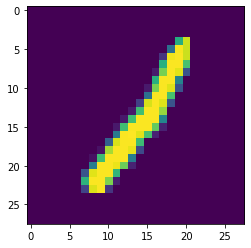

In [7]:
from random import randrange

temp = train_loader.dataset[randrange(10)][0].numpy()
temp = np.reshape(a=temp, newshape=(temp.shape[1], temp.shape[2]))
plt.imshow(temp)

# **6. Implementing CNN (Architecture)**

In [8]:
class ConvNet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        #Layer sizes
        hidden1 = 512
        hidden2 = 128
        hidden3 = 64
        
        #Convolutions & Pooling
        self.conv1 = nn.Conv2d(1, 32, 3)   #input channel size, output channel size, kernel size
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)     #size, stride
        
        #Fully connected layers
        self.fc1 = nn.Linear(1600, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, 10)
        
        self.dropout = nn.Dropout(model_Dropout)
    
    def forward(self, x):
        
        #Feature learning
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        #Classification
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        
        return F.log_softmax(x)

# **7. Model (Training & Validation)**

In [9]:
recog_model = ConvNet()#.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(recog_model.parameters(), lr=learning_Rate, weight_decay = weight_Decay)

steps = 0

accuracy_list = []
train_losses, valid_losses = [], []

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy 1: 25.0%
Accuracy 2: 86.00000143051147%
Accuracy 3: 93.99999976158142%
Accuracy 4: 100.0%
Accuracy 5: 93.00000071525574%
Accuracy 6: 94.9999988079071%
Accuracy 7: 94.9999988079071%
Accuracy 8: 97.00000286102295%
Accuracy 9: 97.00000286102295%
Accuracy 10: 95.99999785423279%
Accuracy 11: 100.0%
Accuracy 12: 97.00000286102295%
Final training loss: 0.0587239434131022
Final validation loss: tensor(0.0847)


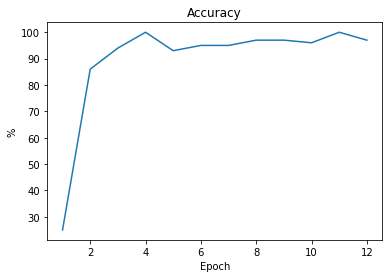

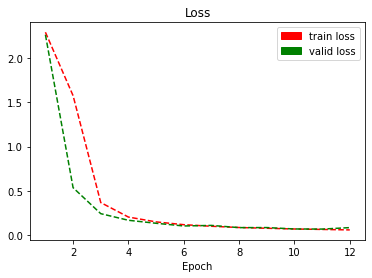

In [10]:
for e in range (epochs):
    
    running_loss = 0
    
    for images, labels in train_loader:
        
        #GPU support
        #images = images.to(device)
        #labels = labels.to(device)
        
        #Forward
        output = recog_model(images)
        loss = criterion(output, labels)
        
        #Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        
        valid_loss = 0
        accuracy = 0
        
        #Evaluate the model
        with torch.no_grad():
            recog_model.eval()
            
            for images, labels in valid_loader:
                
                output = recog_model(images)
                valid_loss += criterion(output, labels)
                
                ps = torch.exp(output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.reshape(*top_class.shape)
                
                accuracy = torch.mean(equals.type(torch.FloatTensor))
                
        print('Accuracy ' + str(e+1) + ': ' + str(accuracy.item() * 100) + '%')
                
        #Store values for plotting
        accuracy_list.append(accuracy.item() * 100)
        train_losses.append(running_loss / len(train_loader))
        valid_losses.append(valid_loss / len(valid_loader))

#Print the losses
print('Final training loss: ' + str(train_losses[epochs-1]))
print('Final validation loss: ' + str(valid_losses[epochs-1]))
        
### Plot ###
xAxis = []
for i in range(epochs):
    xAxis.append(i+1)
    
#Accuracy graph
plt.plot(xAxis, accuracy_list)
plt.ylabel('%')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.show()

#Loss graph
plt.plot(xAxis, train_losses, 'r--', xAxis, valid_losses, 'g--')
red_line = mpatches.Patch(color='red', label='train loss')
green_line = mpatches.Patch(color='green', label='valid loss')
plt.legend(handles=[red_line, green_line])
plt.xlabel('Epoch')
plt.title('Loss')
plt.show()

# **8. Submission (Test)**

In [11]:
#Evaluate the model
with torch.no_grad():
    recog_model.eval()
            
    for images in test_loader:
              
        output = recog_model(images)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)

print('Done')        

Done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [12]:
#results = recog_model.predict(test_loader)
results = np.argmax(output, axis = 1) #results por output
results = pd.Series(results, name = 'Label')
results

0        2
1        0
2        9
3        9
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64

In [13]:
submission = pd.concat([pd.Series(range(1, 28001), name = 'ImageId'), results], axis = 1)
submission.to_csv('submission.csv', index = False)